pretrained model : resnet18

loss_fn : CrossEntropyLoss

optimizer : adam

epoch: 5

batch-size : 64 -> 32

data augmentation : transforms.RandomHorizontalFlip(),

fc layer : relu

lr : 0.0001

In [253]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize

import time

In [254]:
train_path = 'input/data/train'
train_image_dir_path = os.path.join(train_path, 'images')

Dataset 생성

모든 train data의 path를 가져와 라벨링 진행

In [255]:
def search(dirname, result): # 하위 목록의 모든 파일을 찾는 함수
    try:
        filenames = os.listdir(dirname)
        for filename in filenames:
            if filename[0] == '.': # .으로 시작하는 애들 거름
                continue
            full_filename = os.path.join(dirname, filename)
            if os.path.isdir(full_filename):
                search(full_filename, result)
            else:
                ext = os.path.splitext(full_filename)[-1] # 확장자 체크
                if ext:
                    result.append(full_filename)
        
    except PermissionError:
        print('Permission Error')
        pass

In [256]:
all_path = list()
search(train_image_dir_path, all_path)

train의 데이터 디렉토리는 2700개로, 각각의 이미지 파일(incorrect, mask1~5, normal)을 곱한 갯수가 나옵니다.

In [257]:
len(all_path) # 2700 * 7

18900

In [258]:
all_path[:10]

['input/data/train/images/001752_male_Asian_53/mask5.jpg',
 'input/data/train/images/001752_male_Asian_53/mask4.jpg',
 'input/data/train/images/001752_male_Asian_53/mask2.jpg',
 'input/data/train/images/001752_male_Asian_53/mask3.jpg',
 'input/data/train/images/001752_male_Asian_53/normal.jpg',
 'input/data/train/images/001752_male_Asian_53/mask1.jpg',
 'input/data/train/images/001752_male_Asian_53/incorrect_mask.jpg',
 'input/data/train/images/005127_female_Asian_51/mask5.jpg',
 'input/data/train/images/005127_female_Asian_51/mask4.jpg',
 'input/data/train/images/005127_female_Asian_51/mask2.jpg']

파일의 확장자는 jpg, png, jpeg로 3종류가 있습니다.

In [259]:
exts = list()
for word in all_path:
    ext = os.path.splitext(word)[-1]
    if ext not in exts:
        exts.append(ext)
print(exts) # jpg, png, jpeg

['.jpg', '.png', '.jpeg']


In [260]:
all_path = sorted(all_path)

라벨링을 하는 함수입니다. 조건에 따라 label에 숫자를 더해주는 식으로 만들었습니다.

In [261]:
def labeling(name):
    label = 0
    info, mask_type = name.split('/')[-2:]
    info = info.split('_')
    gender, age = info[1], int(info[3])
    
    # 마스크 구별
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 12
    
    # gender 구별
    if gender == 'female':
        label += 3
    
    # 나이 구별
    if 30 <= age and age < 60:
        label += 1
    elif age >= 60:
        label += 2
    
    return label

path, label을 컬럼으로 갖는 dataframe을 생성해줍니다.

In [262]:
train_path_label = pd.DataFrame(all_path, columns = ['path'])

train_path_label['label'] = train_path_label['path'].map(lambda x: labeling(x))
train_path_label

,path,label
0,input/data/train/images/000001_female_Asian_45...,10
1,input/data/train/images/000001_female_Asian_45...,4
2,input/data/train/images/000001_female_Asian_45...,4
3,input/data/train/images/000001_female_Asian_45...,4
4,input/data/train/images/000001_female_Asian_45...,4
...,...,...
18895,input/data/train/images/006959_male_Asian_19/m...,0
18896,input/data/train/images/006959_male_Asian_19/m...,0
18897,input/data/train/images/006959_male_Asian_19/m...,0
18898,input/data/train/images/006959_male_Asian_19/m...,0


In [263]:
# train_path_label.to_csv('./train_path_label.csv', index=False, encoding='utf-8')
# train_path_label = pd.read_csv('./train_path_label.csv', encoding='utf-8')

dataset을 상속받아 만든 CustomDataset입니다. transform은 size를 [512, 384]로 변형하고, Tensor로 만들고, 정규화를 해주었습니다.

In [264]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_label, transform):
        self.X = img_paths_label['path']
        self.y = img_paths_label['label']
        self.transform = transform
        
    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)
    
    def __len__(self):
        return len(self.X)

In [265]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    transforms.RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

train, valid를 나누는 부분입니다.

label의 비율을 유지하면서 나눴습니다.

+ 기존 방법 대신StratifiedKFold 사용을 시도했습니다.

In [266]:
# 원본
# from sklearn.model_selection import train_test_split
# train, valid = train_test_split(train_path_label, test_size=0.2,
#                                shuffle=True, stratify=train_path_label['label'],
#                                random_state=34)

DataLoader
- index를 사용한 Dataloader 정의
- getDataloader 함수 설명
    1. Pytorch Dataset, train 인덱스, valid 인덱스, batch size를 전달받아 Train, Valid DataLoader 객체를 반환합니다.
    2. torch.utils.data.Subset 객체는 데이터셋과 해당 데이터셋의 인덱스를 전달받아 Subset 객체를 생성합니다. 생성한 Subset 객체를 사용해 DataLoader 객체를 반환합니다.

In [267]:
def getDataloader(dataset, train_idx, valid_idx, batch_size, num_workers):
    # 인자로 전달받은 dataset에서 train_idx에 해당하는 Subset 추출
    train_set = torch.utils.data.Subset(dataset,
                                        indices=train_idx)
    # 인자로 전달받은 dataset에서 valid_idx에 해당하는 Subset 추출
    val_set   = torch.utils.data.Subset(dataset,
                                        indices=valid_idx)
    
    # 추출된 Train Subset으로 DataLoader 생성
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        num_workers=num_workers,
        drop_last=True,
        shuffle=True
    )
    # 추출된 Valid Subset으로 DataLoader 생성
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
        num_workers=num_workers,
        drop_last=True,
        shuffle=False
    )
    
    # 생성한 DataLoader 반환
    return train_loader, val_loader

dataloader를 정의했습니다. batchsize는 64로 했고 shuffle을 했습니다.

In [268]:
BATCH_SIZE = 32

In [269]:
dataset = CustomDataset(train_path_label, transform)

custom_dataloader = DataLoader(dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True
                             )

모델
모델은 pretrain된 resnet18을 가져왔습니다. 이 모델의 마지막 fc층만 저희의 과제인 18개의 class로 변경해줍니다.

In [270]:
resnet18 = torchvision.models.resnet18(pretrained=True)

In [271]:
import math

OUTPUT_CLASS_NUM = 18
resnet18.fc = torch.nn.Linear(in_features=512, out_features=OUTPUT_CLASS_NUM, bias=True) # output 18개로

# xavier uniform
torch.nn.init.xavier_uniform_(resnet18.fc.weight)
stdv = 1. / math.sqrt(resnet18.fc.weight.size(1))
resnet18.fc.bias.data.uniform_(-stdv, stdv)

resnet18.fc.weight.shape[0]

18

In [272]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

아래 대부분의 코드가 부스트캠프에서 학습 자료나 과제로 제공받았던 코드를 거의 그대로 사용했습니다.

설명도 주석도 잘 달려 있어서 그대로 가져왔습니다.

epoch는 5, lr은 0.0001로 주었습니다.

추후에 lr scheduler로 lr을 변경해보는 방법도 좋을 것 같습니다.

In [273]:
resnet18.to(device)

LEARNING_RATE = 0.0001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 5 # 학습 때 mnist train data set을 얼마나 많이 학습할 지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross Entropy Loss를 objective function으로 사용
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함


In [274]:
# 5-fold Stratified KFold 5개의 fold를 형성하고 5번 Cross Validation을 진행합니다.
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import KFold

best_test_accuracy = 0.
best_test_loss = 9999.
start = time.time()  # 시작 시간 저장

# skf 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)
# kfold = KFold(n_splits=4, shuffle=False)

# skf에서 사용할 labels 설정
labels = [i for i in train_path_label['label']]

BATCH_SIZE = 32
num_workers = 4

print(train_path_label)
temp_idx = 0
for train_index, validate_index in skf.split(train_path_label, labels):
#     print(train_index, validate_index)
    temp_idx += 1
    train = train_path_label.iloc[train_index]
    valid = train_path_label.iloc[validate_index]

    train_dataset = CustomDataset(train, transform)

    train_dataloader = DataLoader(train_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=False
                                 )

    valid_dataset = CustomDataset(valid, transform)

    valid_dataloader = DataLoader(valid_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

    dataloaders = {
        "train": train_dataloader,
        "test": valid_dataloader,
    }
    for epoch in range(NUM_EPOCH):

        for phase in ["train", "test"]:
            running_loss = 0.
            running_acc = 0.
#             # 네트워크 모델을 train 모드로 두어 gradient를 계산하고, 
#             # 여러 sub module (배치 정규화, 드롭아웃 등)이 train_mode로 작동할 수 있게 함.
            if phase == "train":
                resnet18.train()
            # 네트워크 모델을 eval 모드로 두어 여러 sub module들이 eval mode로 작동할 수 있게 함.
            elif phase == "test":
                resnet18.eval()
            
            for ind, (images, labels) in enumerate(dataloaders[phase]):
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함.

                # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
                with torch.set_grad_enabled(phase == "train"):
                    logits = resnet18(images)
                    # 모델에서 linear 값으로 나오는 예측 값([0.9, 1.2, 3.2, 0.1, -0.1, ...])에서 최대 output index를 찾아 예측 레이블([2])로 변경함
                    _, preds = torch.max(logits, 1)
                    loss = loss_fn(logits, labels)

                    if phase == "train":
                        loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient를 계산
                        optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

                running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
                running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장

            # 한 epoch이 모두 종료되었을 때,
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_acc / len(dataloaders[phase].dataset)

            seconds = int(time.time() - start)
            print(f"현재 epoch-{temp_idx}-{epoch}의 {phase}-데이터 셋에서 평균 Loss: {epoch_loss:.3f}, 평균 Accuracy: {epoch_acc:.3f}")
            print(f"소요 시간: {seconds // 60}분 {seconds % 60}초")  # 현재시각 - 시작시간 = 실행 시간
#             print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss: {epoch_loss:.3f}, 평균 Accuracy: {epoch_acc:.3f}")
#             print(f"소요 시간: {seconds // 60}분 {seconds % 60}초")  # 현재시각 - 시작시간 = 실행 시간

            # phase가 test일 때
            if phase == "test":
                # best accuracy 계산
                if best_test_accuracy < epoch_acc:
                    best_test_accuracy = epoch_acc
                # best loss 계산
                if best_test_loss > epoch_loss:
                    best_test_loss = epoch_loss

                
seconds = int(time.time() - start)
print("학습 종료!")
print(f"최고 accuracy: {best_test_accuracy}, 최고 낮은 loss: {best_test_loss}")
print(f"소요 시간: {seconds // 60}분 {seconds % 60}초")  # 현재시각 - 시작시간 = 실행 시간

                                                    path  label
0      input/data/train/images/000001_female_Asian_45...     10
1      input/data/train/images/000001_female_Asian_45...      4
2      input/data/train/images/000001_female_Asian_45...      4
3      input/data/train/images/000001_female_Asian_45...      4
4      input/data/train/images/000001_female_Asian_45...      4
...                                                  ...    ...
18895  input/data/train/images/006959_male_Asian_19/m...      0
18896  input/data/train/images/006959_male_Asian_19/m...      0
18897  input/data/train/images/006959_male_Asian_19/m...      0
18898  input/data/train/images/006959_male_Asian_19/m...      0
18899  input/data/train/images/006959_male_Asian_19/n...     12

[18900 rows x 2 columns]
현재 epoch-1-0의 train-데이터 셋에서 평균 Loss: 1.122, 평균 Accuracy: 0.653
소요 시간: 2분 19초
현재 epoch-1-0의 test-데이터 셋에서 평균 Loss: 2.442, 평균 Accuracy: 0.330
소요 시간: 2분 43초
현재 epoch-1-1의 train-데이터 셋에서 평균 Loss: 0.713, 평균 Accura

In [275]:
print(train)

                                                    path  label
0      input/data/train/images/000001_female_Asian_45...     10
1      input/data/train/images/000001_female_Asian_45...      4
2      input/data/train/images/000001_female_Asian_45...      4
3      input/data/train/images/000001_female_Asian_45...      4
4      input/data/train/images/000001_female_Asian_45...      4
...                                                  ...    ...
18042  input/data/train/images/006615_male_Asian_19/m...      0
18043  input/data/train/images/006615_male_Asian_19/m...      0
18044  input/data/train/images/006615_male_Asian_19/m...      0
18045  input/data/train/images/006615_male_Asian_19/n...     12
18047  input/data/train/images/006616_male_Asian_20/m...      0

[15120 rows x 2 columns]


In [276]:
# train[0].shape()

dataloader를 정의했습니다. batchsize는 64로 했고 shuffle을 했습니다.

In [277]:
PATH = '/input'

torch.save(resnet18, PATH)

In [278]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

검증

In [279]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0, 0
        model.eval()
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.to(device))
            _, y_pred = torch.max(model_pred, 1)  # 행으로 비교
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_acc = (n_correct/n_total)
        #model_train()
    return val_acc

In [280]:
func_eval(resnet18, valid_dataloader, device)

0.6968253968253968

In [281]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred, 1)
            
            result.append([valid.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
    return result

In [282]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle=False)

check_eval_df = check_eval(valid, valid_testing_dataloader, resnet18, device)
check_eval_df

,path,pred,target
0,input/data/train/images/003997_male_Asian_59/i...,7,7
1,input/data/train/images/003997_male_Asian_59/m...,1,1
2,input/data/train/images/003997_male_Asian_59/m...,1,1
3,input/data/train/images/003997_male_Asian_59/m...,1,1
4,input/data/train/images/003997_male_Asian_59/m...,1,1
...,...,...,...
3775,input/data/train/images/006959_male_Asian_19/m...,0,0
3776,input/data/train/images/006959_male_Asian_19/m...,0,0
3777,input/data/train/images/006959_male_Asian_19/m...,0,0
3778,input/data/train/images/006959_male_Asian_19/m...,0,0


잘못 예측한 데이터 리스팅

In [283]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,pred,target
0,input/data/train/images/004006_male_Asian_54/m...,0,1
1,input/data/train/images/004006_male_Asian_54/m...,0,1
2,input/data/train/images/004006_male_Asian_54/m...,0,1
3,input/data/train/images/004006_male_Asian_54/m...,0,1
4,input/data/train/images/004006_male_Asian_54/m...,0,1
...,...,...,...
1137,input/data/train/images/006424_female_Asian_18...,0,3
1138,input/data/train/images/006424_female_Asian_18...,0,3
1139,input/data/train/images/006424_female_Asian_18...,0,3
1140,input/data/train/images/006424_female_Asian_18...,0,3


f1 score 측정

In [284]:
# !pip install seaborn

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

함수 정의
- precision, recall, f1-score, confusion matrix 출력

In [286]:
def report():
    y_test, y_pred = check_eval_df['target'], check_eval_df['pred']
    print(classification_report(y_test, y_pred))
    print('resnet18 Accuracy:', np.mean(y_pred == y_test))
    ax = plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=0.5, fmt='.1f', annot=True)

              precision    recall  f1-score   support

           0       0.58      1.00      0.73       554
           1       0.92      0.49      0.64       409
           2       1.00      0.66      0.80        83
           3       0.55      0.99      0.71       727
           4       0.99      0.16      0.28       818
           5       0.94      0.57      0.71       109
           6       0.87      1.00      0.93       111
           7       1.00      0.73      0.85        82
           8       0.93      0.81      0.87        16
           9       0.77      0.99      0.86       146
          10       0.97      0.70      0.81       163
          11       1.00      0.36      0.53        22
          12       0.91      1.00      0.95       111
          13       0.93      0.79      0.85        81
          14       0.81      0.76      0.79        17
          15       0.80      1.00      0.89       145
          16       0.93      0.76      0.83       164
          17       1.00    

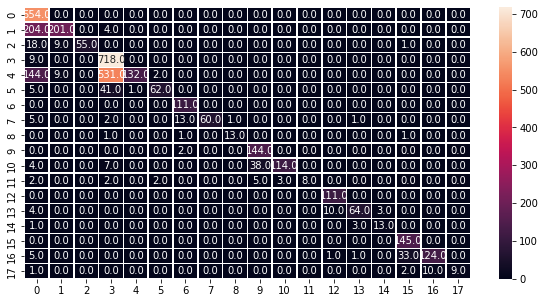

In [287]:
report()

데이터 저장

In [288]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [289]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = 'input/data/eval'

In [290]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    transforms.RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
# model = MyModel(num_classes=18).to(device)
PATH = '/input'
model = torch.load(PATH)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!


In [291]:
test_data = pd.read_csv('input/data/eval/submission.csv', encoding='utf-8')

In [292]:
classes = dict()

for cla in test_data['ans']:
    if cla in classes:
        classes[cla] += 1
    else:
        classes[cla] = 1
        
classes = sorted(classes.items())
print(classes)

[(0, 4538), (1, 1003), (2, 529), (3, 2264), (4, 483), (5, 498), (6, 493), (7, 323), (8, 201), (9, 323), (10, 223), (11, 44), (12, 486), (13, 240), (14, 338), (15, 320), (16, 254), (17, 40)]
